In [1]:
import os
os.chdir("..")

In [2]:
import pandas as pd
import numpy as np

import pymc as pm
import arviz as az

import matplotlib.pyplot as plt

import preprocess

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Focus of the Research Question

**Posterior Uncertainity.**

That is routes with:
    many observations indicates tighter posterior (low uncertainty)
    few observations indicates wider posterior (high uncertainty)

This not only help us understand that a certain “Route A is worse than Route B” but also quantify uncertainty.


**Insights we get from this analysis:**

- Some routes appear very delayed, but uncertainty is high (few trains)
- Some routes have stable, well-estimated delays (many trains)

**Helpful for:**
- passengers
- planners
- reliability analysis

### Statistical problem

**Observed data**

For each route $r$:

- Delays:   $y_{r1},\ y_{r2},\ \ldots,\ y_{rn_r}$
- Number of observations:   $n_r$

**We want to:**

- an estimate of the **mean delay per route**, and
- its **uncertainty**, and
- to compare **frequent vs. infrequent** routes.



### Model choice

Bayesian hierarchical (multilevel) model

**Why this model?**

Better results if we use **Partial pooling** method, because its *too noisy* to estimate each route independently *too simplistic* to pool all routes together.

So, since each route has its own mean delay, we assume these route means come from a common distribution.

This inturn would result in

- stabilizing estimates for infrequent routes
- naturally increasing uncertainty where data is sparse

### Mathematical form of the Bayesian model

**Likelihood**

For each observation (route $r$ on day $i$):

$$y_{ri} \sim \mathcal{N}(\mu_r,\,\sigma)$$

**Route-level parameters**

$$
\mu_r \sim \mathcal{N}(\mu_{\mathrm{global}},\,\tau)
$$

**Hyperpriors**

$$
 \mu_{\mathrm{global}} \sim \mathcal{N}(0,\,10)
$$

$$
 \sigma \sim \mathrm{HalfNormal}(10)
$$

$$
 \tau \sim \mathrm{HalfNormal}(10)
$$

**Where**

- $\mu_r$: average delay for route $r$
- $\tau$: how much routes differ from each other
- $\sigma$: day-to-day noise

In [5]:
# Load Data
df = preprocess.load_data_as_df()
df = preprocess.add_route_identifier(df)
df = preprocess.add_route_identifier(df)

In [6]:
# Sample data: only include top and busiest routes

route_counts = (
    df.groupby("route_id")
      .size()
      .sort_values(ascending=False)
)

# Keep top N routes
TOP_N_ROUTES = 50

major_routes = route_counts.head(TOP_N_ROUTES).index

df = df[df["route_id"].isin(major_routes)]

In [95]:
route_stats = (
    df.groupby("route_id")
      .agg(
          mean_delay=("delay_in_min", "mean"),
          n_obs=("delay_in_min", "size")
      )
      .reset_index()
)

# Filter very rare routes
route_stats = route_stats[route_stats["n_obs"] >= 10]

In [97]:
# Encode routes as indices

route_codes, route_idx = np.unique(
    df["route_id"], return_inverse=True
)

delays = df["delay_in_min"].values

In [99]:
with pm.Model() as model:

    # Hyperpriors
    mu_global = pm.Normal("mu_global", mu=0, sigma=10)
    tau = pm.HalfNormal("tau", sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=10)

    # Route-level means
    mu_route = pm.Normal(
        "mu_route",
        mu=mu_global,
        sigma=tau,
        shape=len(route_codes)
    )

    # Likelihood
    delay_obs = pm.Normal(
        "delay_obs",
        mu=mu_route[route_idx],
        sigma=sigma,
        observed=delays
    )

    trace = pm.sample(2000, tune=1000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_global, tau, sigma, mu_route]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 588 seconds.


In [116]:
# Measuring uncertainty per route
posterior = az.extract(trace, var_names=["mu_route"])

route_uncertainty = posterior.std(axis=1)

route_stats["posterior_sd"] = route_uncertainty

In [117]:
# Frequent vs infrequent comparison
q25 = route_stats["n_obs"].quantile(0.25)
q75 = route_stats["n_obs"].quantile(0.75)

frequent = route_stats[route_stats["n_obs"] >= q75]
infrequent = route_stats[route_stats["n_obs"] <= q25]

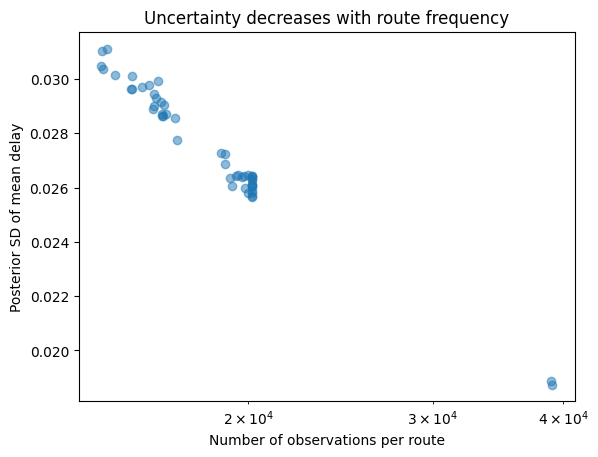

In [118]:
# Uncertainty vs number of observations

plt.scatter(
    route_stats["n_obs"],
    route_stats["posterior_sd"],
    alpha=0.5
)
plt.xscale("log")
plt.xlabel("Number of observations per route")
plt.ylabel("Posterior SD of mean delay")
plt.title("Uncertainty decreases with route frequency")
plt.show()

In [ ]:
# Posterior distributions (few example routes)
# az.plot_posterior(posterior[5])

**Conclusion:** A hierarchical Bayesian model allows us to quantify uncertainty in route-level delay estimates and to naturally account for varying data availability across routes. This makes it possible to compare frequently and infrequently used routes not only in terms of expected delay, but also in terms of how confident we are in those estimates.